## Data


In [ ]:
#Extract data of 2019 May and 2020 May
import pandas as pd
url_19 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date%20between%20%272019-05-01T12:00:00%27%20and%20%272019-05-31T12:00:00%27%20&$limit=250000'
df_19 = pd.read_json(url_19)
#df_19.head()


url_20 = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=created_date%20between%20%272020-05-01T12:00:00%27%20and%20%272020-05-31T12:00:00%27%20&$limit=200000'
df_20 = pd.read_json(url_20)
#df_20.head()

print(df_19.shape, df_20.shape)

(237224, 41) (198679, 41)


In [ ]:
# filter columns needed
used_columns = ['unique_key', 'created_date', 'closed_date', 
       'complaint_type', 'incident_zip',  'borough',
       'location', 'resolution_description']
df_19 = df_19[used_columns]
df_20 = df_20[used_columns]

df_19 = df_19.dropna()
df_20 = df_20.dropna()
print(df_19.shape, df_20.shape)

(198594, 8) (184741, 8)


In [ ]:
df_20.head()

,complaint_type,location
0,Street Light Condition,"{'latitude': '40.8516867', 'longitude': '-73.8..."
1,Street Light Condition,"{'latitude': '40.5843873', 'longitude': '-73.8..."
2,Street Light Condition,"{'latitude': '40.8450793', 'longitude': '-73.8..."
3,Overgrown Tree/Branches,"{'latitude': '40.68923416311884', 'longitude':..."
4,Non-Emergency Police Matter,"{'latitude': '40.683387764611375', 'longitude'..."


In [ ]:
# created date and closed date: use only yyyyy-mm-dd
df_19['created_date'] = [str(date)[:10] for date in df_19['created_date']]
df_20['created_date'] = [str(date)[:10] for date in df_20['created_date']]
df_19['closed_date'] = [str(date)[:10] for date in df_19['closed_date']]
df_20['closed_date'] = [str(date)[:10] for date in df_20['closed_date']]

In [ ]:
print(df_19['complaint_type'].groupby(df_19['complaint_type']).count()
print(df_20['complaint_type'].groupby(df_20['complaint_type']).count()


23181
41630


In [ ]:
pd.DataFrame(df_20['complaint_type'].groupby(df_20['borough']).count())

,complaint_type
borough,
BRONX,45232
BROOKLYN,52458
MANHATTAN,39279
QUEENS,40455
STATEN ISLAND,7305
Unspecified,12


## Visualization

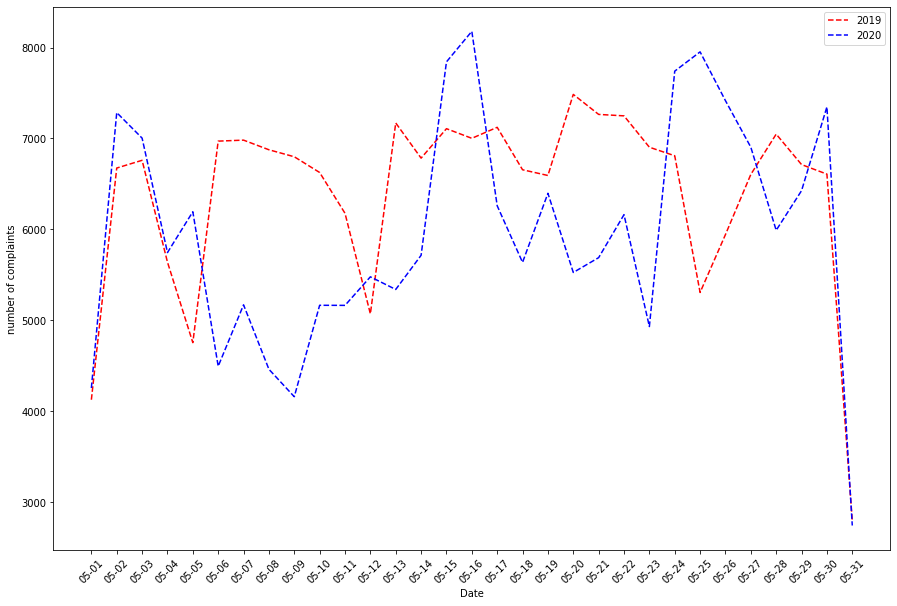

In [ ]:
# plot complaints number by date over 30 days for 19 and 20
import matplotlib.pyplot as plt
import numpy as np
x = [date[5:] for date in np.unique(df_20['created_date'])]
y_1 = df_19['complaint_type'].groupby(df_19['created_date']).count()
y_2 = df_20['complaint_type'].groupby(df_20['created_date']).count()

plt.figure(figsize=(15,10))
plt.plot(x, y_1, 'r--', x, y_2, 'b--')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('number of complaints')
plt.legend(['2019', '2020'],loc='upper right')
plt.show()

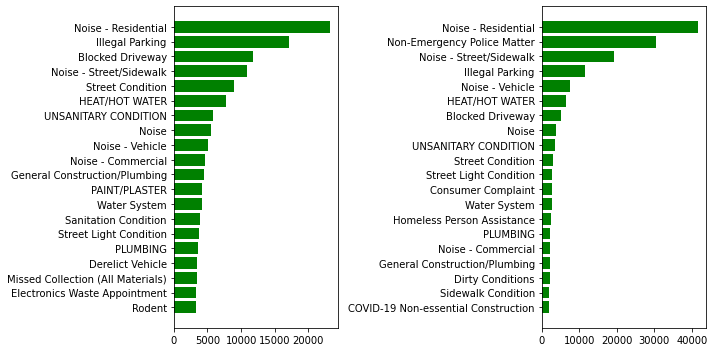

In [ ]:
# plot the number of top 20 types of complaint  19 vs. 20
top_complaints = 20
complaints_by_type = df_19['complaint_type'].groupby(df_19['complaint_type']).count()
complaints_by_type = complaints_by_type.sort_values(ascending=False)
complaints_by_type = complaints_by_type[:top_complaints]
y = complaints_by_type.index
width = complaints_by_type.values

complaints_by_type_20 = df_20['complaint_type'].groupby(df_20['complaint_type']).count()
complaints_by_type_20 = complaints_by_type_20.sort_values(ascending=False)
complaints_by_type_20 = complaints_by_type_20[:top_complaints]
y_2 = complaints_by_type_20.index
width_2 = complaints_by_type_20.values

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.barh(y[::-1], width[::-1],  color = 'g')
ax2.barh(y_2[::-1], width_2[::-1],  color = 'g')
f.tight_layout()
plt.show()

## Prediction analysis
Use resolution description to predict days to resolve 

In [ ]:
import numpy as np
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
from datetime import datetime

df_19['created_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in df_19['created_date']]
df_19['closed_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in df_19['closed_date']]

df_20['created_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in df_20['created_date']]
df_20['closed_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in df_20['closed_date']]


In [ ]:
df_19['days_to_resolve'] = (df_19['closed_date'] - df_19['created_date']).astype('timedelta64[D]').values.astype(int)
df_20['days_to_resolve'] = (df_20['closed_date'] - df_20['created_date']).astype('timedelta64[D]').values.astype(int)

In [ ]:
## Use only two columns
my_data_19 = df_19[['resolution_description', 'days_to_resolve']]
my_data_20 = df_20[['resolution_description', 'days_to_resolve']]
my_data_19.reset_index(inplace = True, drop = True)
my_data_20.reset_index(inplace = True, drop = True)
my_data_19 = my_data_19[my_data_19['days_to_resolve']>=0]
my_data_20 = my_data_20[my_data_20['days_to_resolve']>=0]

In [ ]:
# Sample 1000 rows 
sample_19 = my_data_19.sample(1000)
sample_20 = my_data_20.sample(1000)
#sample_19

In [ ]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 
# convert to lowercase string 
sample_19['description_box'] = [str(des) for des in sample_19['resolution_description']]
sample_19['description_box'] = [des.lower() for des in sample_19['description_box']]
# Strip all punctuation and numeric values 
table = str.maketrans('', '', string.punctuation)
sample_19['description_box'] = [des.translate(table) for des in sample_19['description_box']]
#  Tokenization : In this each entry in the corpus will be broken into set of words
sample_19['description_box'] = [word_tokenize(des) for des in sample_19['description_box']]

sample_19.head()

,resolution_description,days_to_resolve,description_box
170612,The Department of Housing Preservation and Dev...,8,"[the, department, of, housing, preservation, a..."
192733,The Police Department responded to the complai...,0,"[the, police, department, responded, to, the, ..."
14935,The Department of Environmental Protection inv...,0,"[the, department, of, environmental, protectio..."
117518,The Department of Housing Preservation and Dev...,3,"[the, department, of, housing, preservation, a..."
123929,The Department of Transportation inspected the...,4,"[the, department, of, transportation, inspecte..."


In [ ]:
## Remove words with less semantic meaning and lemmatize

# create tag map 
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Remove Stop words, Non-Numeric and perfom word Lemmenting.
for index in sample_19.index:
  des = sample_19['description_box'][index]
  #print(des)
  Final_words = []
  
  Word_Lemmatized = WordNetLemmatizer()
  # identify if the word is Noun(N) or Verb(V) or something else using post tag
  for word, tag in pos_tag(des):
      # remove stop words
      if word not in stopwords.words('english') and word.isalpha():
          word_Final = Word_Lemmatized.lemmatize(word,tag_map[tag[0]])
          # print(word)
          # print(word_Final)
          # print(tag[0])
          # print(tag_map[tag[0]])
          Final_words.append(word_Final)
  # The final processed set of words for each iteration will be stored in 'cleaned_text'(in the format of lists) and 'text_final'(in the format of strings)
  #selected.at[index,'Cleaned_Text'] = Final_words
  sample_19.loc[index, 'description_box'] = str(Final_words)
    
sample_19.head()

,resolution_description,days_to_resolve,description_box
170612,The Department of Housing Preservation and Dev...,8,"['department', 'housing', 'preservation', 'dev..."
192733,The Police Department responded to the complai...,0,"['police', 'department', 'respond', 'complaint..."
14935,The Department of Environmental Protection inv...,0,"['department', 'environmental', 'protection', ..."
117518,The Department of Housing Preservation and Dev...,3,"['department', 'housing', 'preservation', 'dev..."
123929,The Department of Transportation inspected the...,4,"['department', 'transportation', 'inspect', 'c..."


In [ ]:
## Quantize days_to_resolve
sample_19['days_to_resolve'] = pd.cut(sample_19['days_to_resolve'], 10, labels = False)
sample_19.head()

,resolution_description,days_to_resolve,description_box
170612,The Department of Housing Preservation and Dev...,0,"['department', 'housing', 'preservation', 'dev..."
192733,The Police Department responded to the complai...,0,"['police', 'department', 'respond', 'complaint..."
14935,The Department of Environmental Protection inv...,0,"['department', 'environmental', 'protection', ..."
117518,The Department of Housing Preservation and Dev...,0,"['department', 'housing', 'preservation', 'dev..."
123929,The Department of Transportation inspected the...,0,"['department', 'transportation', 'inspect', 'c..."


In [ ]:
sample_19

,resolution_description,days_to_resolve,description_box
170612,The Department of Housing Preservation and Dev...,0,"['department', 'housing', 'preservation', 'dev..."
192733,The Police Department responded to the complai...,0,"['police', 'department', 'respond', 'complaint..."
14935,The Department of Environmental Protection inv...,0,"['department', 'environmental', 'protection', ..."
117518,The Department of Housing Preservation and Dev...,0,"['department', 'housing', 'preservation', 'dev..."
123929,The Department of Transportation inspected the...,0,"['department', 'transportation', 'inspect', 'c..."
...,...,...,...
44003,The Department of Health and Mental Hygiene wi...,3,"['department', 'health', 'mental', 'hygiene', ..."
166898,The Police Department responded to the complai...,0,"['police', 'department', 'respond', 'complaint..."
9696,The Department of Housing Preservation and Dev...,0,"['department', 'housing', 'preservation', 'dev..."
37691,The Department of Buildings investigated this ...,8,"['department', 'building', 'investigate', 'com..."


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(sample_19['description_box'], sample_19['days_to_resolve'], test_size = 0.3,
                                                   random_state = 25)


In [ ]:
# Covert description bag of words to TF-IDF scores
from sklearn.feature_extraction.text import CountVectorizer

# tfidfvector = TfidfVectorizer()
# tfidfvector.fit(sample_19['description_box'])
# x_train_tfidf = tfidfvector.transform(x_train)
# x_test_tfidf = tfidfvector.transform(x_test)

bow_model = CountVectorizer()
bow_model.fit(sample_19['description_box'])
x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

pd.DataFrame(x_train_bow.toarray(), columns = bow_model.get_feature_names())

,able,accept,acceptable,access,accord,act,action,additional,address,adequate,adjoin,administrative,administratively,advise,affair,agency,ago,airnoise,already,andor,another,apartment,application,appointment,appropriat,appropriate,approval,approve,area,arrival,asbestos,ask,assign,assistance,attempt,attention,available,back,base,basin,...,symptom,system,take,taxi,team,temporary,tenant,test,therefore,time,timeframe,tlc,transport,transportation,tree,trial,twice,type,unable,upon,use,usually,utility,vacate,valid,vehicle,verify,violation,visit,warrant,warranted,water,website,within,work,would,write,wwwnycgovhpd,year,york
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
696,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
698,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(pd.DataFrame(x_train_bow, columns = bow_model.get_feature_names()))

     able  accept  acceptable  access  ...  write  wwwnycgovhpd  year  york
0     0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
1     0.0     1.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
2     0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
3     0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
4     0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
..    ...     ...         ...     ...  ...    ...           ...   ...   ...
695   0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
696   0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
697   0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
698   0.0     0.0         0.0     0.0  ...    0.0           0.0   0.0   0.0
699   0.0     0.0         0.0     1.0  ...    0.0           0.0   0.0   0.5

[700 rows x 382 columns]


In [ ]:
# Scale using Standard Scaler
from sklearn.preprocessing import MinMaxScaler
x_train_bow = MinMaxScaler().fit_transform(x_train_bow.toarray())
x_test_bow = MinMaxScaler().fit_transform(x_test_bow.toarray())

In [ ]:
from sklearn.naive_bayes import MultinomialNB 

model = MultinomialNB()
model.fit(x_train_bow, y_train)
score = model.score(x_test_bow, y_test)
print(score)


0.8866666666666667


In [ ]:
predictions = model.predict(x_test_bow)
pd.DataFrame({'predicted class':predictions, 'true class':y_test}, columns = ['predicted class', 'true class'])

,predicted class,true class
184828,0,0
27074,0,0
89530,0,0
2988,0,0
41548,0,0
...,...,...
85727,0,0
59327,0,0
93265,0,0
120930,0,0


## Noise - Residential/Commercial clusters on map

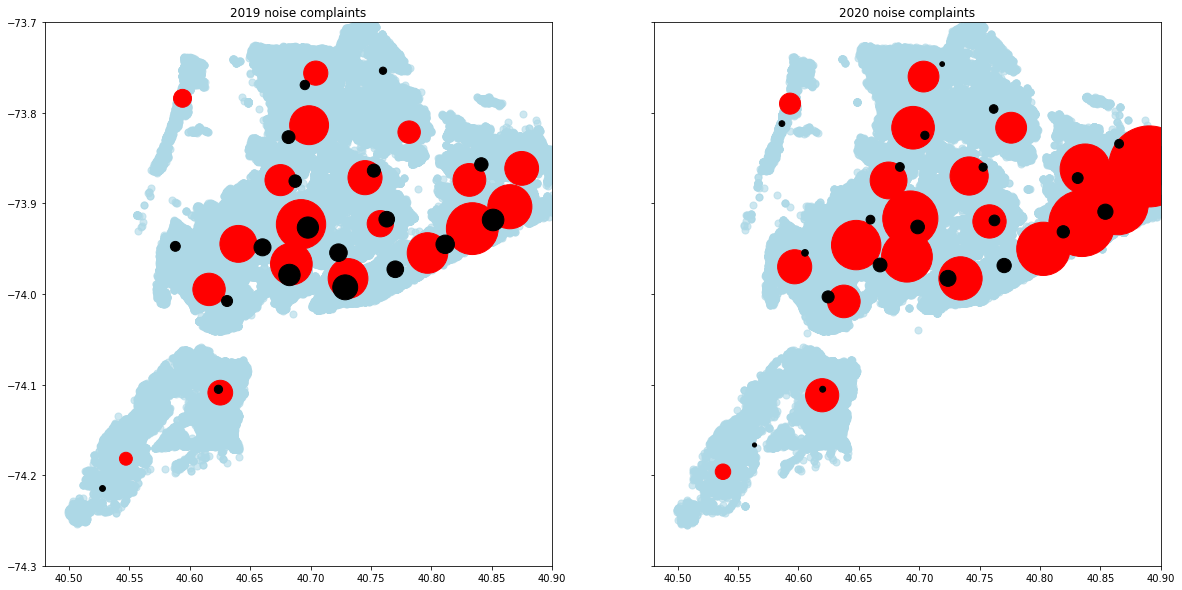

In [ ]:
## 2019 DATA
df_19 = df_19[['complaint_type', 'location']]
df_19 = df_19.dropna()
dots_2019 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in df_19['location']])
residential_df_19 = df_19[df_19['complaint_type'] == 'Noise - Residential']
commercial_df_19 = df_19[df_19['complaint_type'] == 'Noise - Commercial']
residential_complains_2019 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in residential_df_19['location']])
commercial_complains_2019 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in commercial_df_19['location']])
#complains = df_19['complaint_type']

## 2020 DATA
df_20 = df_20[['complaint_type', 'location']]
df_20 = df_20.dropna()
dots_2020 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in df_20['location']])
residential_df_20 = df_20[df_20['complaint_type'] == 'Noise - Residential']
commercial_df_20 = df_20[df_20['complaint_type'] == 'Noise - Commercial']

residential_complains_2020 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in residential_df_20['location']])
commercial_complains_2020 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in commercial_df_20['location']])
#complains = df_20['complaint_type']

## KMEANS
from sklearn.cluster import KMeans
kmeansR_2019 = KMeans(n_clusters=20, random_state=0).fit(residential_complains_2019)
kmeansR_2019.cluster_centers_

kmeansC_2019 = KMeans(n_clusters=20, random_state=1).fit(commercial_complains_2019)
kmeansC_2019.cluster_centers_

kmeansR_2020 = KMeans(n_clusters=20, random_state=2).fit(residential_complains_2020)
kmeansR_2020.cluster_centers_

kmeansC_2020 = KMeans(n_clusters=20, random_state=3).fit(commercial_complains_2020)
kmeansC_2020.cluster_centers_


# Calculate the size of each cluster by the number of data points in the cluster 
kmeansC_2019_df = pd.DataFrame(kmeansC_2019.labels_,columns = ['labels'])
s_C_2019 = kmeansC_2019_df['labels'].groupby(kmeansC_2019_df['labels']).count().values

kmeansR_2019_df = pd.DataFrame(kmeansR_2019.labels_,columns = ['labels'])
s_R_2019 = kmeansR_2019_df['labels'].groupby(kmeansR_2019_df['labels']).count().values

kmeansC_2020_df = pd.DataFrame(kmeansC_2020.labels_,columns = ['labels'])
s_C_2020 = kmeansC_2020_df['labels'].groupby(kmeansC_2020_df['labels']).count().values

kmeansR_2020_df = pd.DataFrame(kmeansR_2020.labels_,columns = ['labels'])
s_R_2020 = kmeansR_2020_df['labels'].groupby(kmeansR_2020_df['labels']).count().values


import matplotlib.pyplot as plt

fig, (ax_2019, ax_2020) = plt.subplots(1, 2, sharey=True, figsize = (20, 10))

ax_2019.scatter(dots_2019[:, 0], dots_2019[:, 1], color='lightblue', alpha=0.6, s=50.)
#ax_2019.scatter(residential_complains_2019[:, 0], residential_complains_2019[:, 1], c = kmeansR_2019.labels_ )
ax_2019.scatter(kmeansR_2019.cluster_centers_[:, 0], kmeansR_2019.cluster_centers_[:, 1], color='red', s = s_R_2019)
#ax_2019.scatter(commercial_complains_2019[:, 0], commercial_complains_2019[:, 1],c = kmeansC_2019.labels_)
ax_2019.scatter(kmeansC_2019.cluster_centers_[:, 0], kmeansC_2019.cluster_centers_[:, 1], color='black', s = s_C_2019)
ax_2019.set_title('2019 noise complaints')

ax_2019.set_ylim(-74.3, -73.7)
ax_2019.set_xlim(40.48, 40.9)

ax_2020.scatter(dots_2020[:, 0], dots_2020[:, 1], color='lightblue', alpha=0.6, s=50.)
#ax_2020.scatter(residential_complains_2020[:, 0], residential_complains_2020[:, 1], c = kmeansR_2020.labels_)
ax_2020.scatter(kmeansR_2020.cluster_centers_[:, 0], kmeansR_2020.cluster_centers_[:, 1], color='red', s = s_R_2020)
#ax_2020.scatter(commercial_complains_2020[:, 0], commercial_complains_2020[:, 1], c = kmeansC_2020.labels_)
ax_2020.scatter(kmeansC_2020.cluster_centers_[:, 0], kmeansC_2020.cluster_centers_[:, 1], color='black', s = s_C_2020)
ax_2020.set_title('2020 noise complaints')

ax_2020.set_ylim(-74.3, -73.7)
ax_2020.set_xlim(40.48, 40.9)

plt.show()


## Covid cases vs. 311 complaints by zip code

In [ ]:
covid_may = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/9b5cd4d9259587d41017804dda6589a7b2ab5b3c/data-by-modzcta.csv')
print(covid_may.shape)
covid_may.head()

(177, 9)


,MODIFIED_ZCTA,NEIGHBORHOOD_NAME,BOROUGH_GROUP,COVID_CASE_COUNT,COVID_CASE_RATE,POP_DENOMINATOR,COVID_DEATH_COUNT,COVID_DEATH_RATE,PERCENT_POSITIVE
0,10001,Chelsea - Clinton,Manhattan,361,1532.06,23563.03,21,89.12,17.56
1,10002,Union Square - Lower East Side,Manhattan,1035,1348.44,76755.41,145,188.91,24.05
2,10003,Union Square - Lower East Side,Manhattan,445,827.11,53801.62,32,59.48,14.34
3,10004,Lower Manhattan,Manhattan,31,849.17,3650.61,1,27.39,14.76
4,10005,Lower Manhattan,Manhattan,61,726.53,8396.11,2,23.82,12.60


In [ ]:
zip_code = pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=NY&timezone=America/New_York&lang=en&use_labels_for_header=true&csv_separator=%3B', sep=';')

In [ ]:
my_df = covid_may.merge(zip_code, left_on='MODIFIED_ZCTA', right_on = 'Zip', how = 'left')


In [ ]:
my_df = my_df[['MODIFIED_ZCTA', 'COVID_CASE_COUNT', 'Latitude', 'Longitude']]
my_df = my_df.dropna()
my_df.shape

(174, 4)

In [ ]:
my_df.head()

,MODIFIED_ZCTA,COVID_CASE_COUNT,Latitude,Longitude
0,10001,361,40.750742,-73.99653
1,10002,1035,40.717040,-73.98700
2,10003,445,40.732509,-73.98935
4,10005,61,40.706019,-74.00858
5,10006,24,40.707904,-74.01342


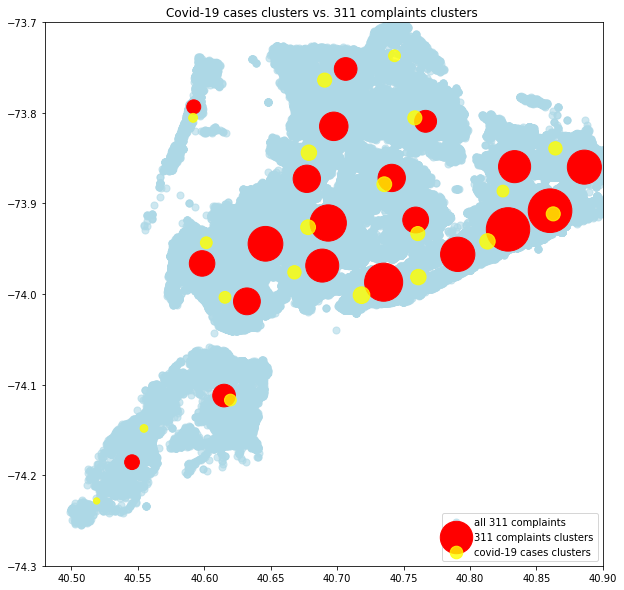

In [ ]:

## 2020 DATA
df_20 = df_20[['complaint_type', 'location']]
df_20 = df_20.dropna()
dots_2020 = np.array([ (float(location['latitude']), float(location['longitude'])) for location in df_20['location']])

#complains_loction = np.array([ (float(location['latitude']), float(location['longitude'])) for location in df_20['location']])


## KMEANS
from sklearn.cluster import KMeans
kmeans_complaints = KMeans(n_clusters=20, random_state=10).fit(dots_2020)

covid_cases_clusters = KMeans(n_clusters = 20, random_state = 12).fit(np.array(my_df[['Latitude', 'Longitude']]))

# Calculate the size of each cluster by the number of data points in the cluster 
kmeans_complaints_df = pd.DataFrame(kmeans_complaints.labels_,columns = ['labels'])
s_complaints = kmeans_complaints_df['labels'].groupby(kmeans_complaints_df['labels']).count().values

covid_df = pd.DataFrame(covid_cases_clusters.labels_,columns = ['labels'])
s_covid = covid_df['labels'].groupby(covid_df['labels']).count().values

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.scatter(dots_2020[:, 0], dots_2020[:, 1], color='lightblue', alpha=0.6, s=50.)


plt.scatter(kmeans_complaints.cluster_centers_[:, 0], kmeans_complaints.cluster_centers_[:, 1], color='red', s = s_complaints*0.1)

plt.scatter(covid_cases_clusters.cluster_centers_[:,0], covid_cases_clusters.cluster_centers_[:,1], color='yellow', s = s_covid*20, alpha = 0.8)

plt.title('Covid-19 cases clusters vs. 311 complaints clusters ')

plt.legend(['all 311 complaints', '311 complaints clusters', 'covid-19 cases clusters'], loc = 'lower right')

plt.ylim(-74.3, -73.7)
plt.xlim(40.48, 40.9)

plt.show()


## Covid Cases vs. Number of complaints by zipcode

In [ ]:
# used_columns = ['complaint_type',  'incident_zip']
# df_20 = df_20[used_columns]
count_by_zip = df_20['complaint_type'].groupby(df_20['incident_zip']).count()
complaints_by_zip = pd.DataFrame(count_by_zip)

In [ ]:
new_df = my_df.merge(complaints_by_zip, left_on='MODIFIED_ZCTA', right_on = 'incident_zip', how = 'left')
new_df = new_df.rename(columns={'complaint_type':'number_of_complaints'})
new_df.head()

,MODIFIED_ZCTA,COVID_CASE_COUNT,Latitude,Longitude,number_of_complaints
0,10001,361,40.750742,-73.99653,721
1,10002,1035,40.717040,-73.98700,1883
2,10003,445,40.732509,-73.98935,1102
3,10005,61,40.706019,-74.00858,122
4,10006,24,40.707904,-74.01342,75


In [ ]:
# calculate Pearson's correlation

# calculate the covariance between two variables

from numpy import cov
from scipy.stats import pearsonr
from scipy.stats import spearmanr

var1 = new_df['COVID_CASE_COUNT']
var2 = new_df['number_of_complaints']

# calculate covariance matrix
covariance = cov(var1, var2)
print(covariance)

#calcualte correlation
corr, _ = pearsonr(var1, var2)
print('Pearsons correlation: %.3f' % corr)

# calculate spearman's correlation
corr_2, _ = spearmanr(var1, var2)
print('Spearmans correlation: %.3f' % corr_2)

[[607912.77234071 400856.66978938]
 [400856.66978938 711486.40369411]]
Pearsons correlation: 0.610
Spearmans correlation: 0.708
